In [1]:
# Import libraries and packages
import pandas as pd
import numpy as np
import re
from gensim import corpora, models, similarities, matutils
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import time

## Data Pre-processing##

In [2]:
# Import Dataset and remove empty rows
df = pd.read_csv('unhappy_customers.csv')

df

,Reviewer_Score,reviews
0,2.9,I am so angry that i made this post available...
1,3.8,My room was dirty and I was afraid to walk ba...
2,4.6,Cleaner did not change our sheet and duvet ev...
3,4.6,The floor in my room was filfy dirty Very bas...
4,3.8,Our room was an overrated disaster room 231 d...
...,...,...
22276,3.8,Can t even stop the car to unload in front of...
22277,3.8,Being 4star hotel except breakfast Breakfast
22278,3.8,Room vas located in different building with n...
22279,4.2,Everything Nothing


In [3]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  22281
Columns  :  2

Features :  ['Reviewer_Score', 'reviews']

Missing values :   7

Unique values :  
 Reviewer_Score       12
reviews           21892
dtype: int64


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22281 entries, 0 to 22280
Data columns (total 2 columns):
Reviewer_Score    22281 non-null float64
reviews           22274 non-null object
dtypes: float64(1), object(1)
memory usage: 348.3+ KB


Reviewer_Score    0
reviews           7
dtype: int64

In [5]:
df = df.sample(frac = 0.05, replace = False, random_state=42)

In [6]:
df

,Reviewer_Score,reviews
5575,4.6,The apparently 4 star hotel is more like a be...
20867,3.3,No vater for free in rom Cue for breakfast an...
21600,2.5,Internet was basically non existent
17767,4.2,Heating system didn t work spent first 2 nigh...
16200,4.2,Small pokey room Very expensive Poor restaura...
...,...,...
554,3.3,Deluxe Double Room is grossly misrepresented ...
5418,3.8,Never recommend this hotel to anyone I am pre...
4579,3.8,Incredibly noisy from 11pm 6am From shouting ...
3638,4.6,Price not helpfull and not responsive to cust...


In [7]:
##nltk.download('punkt')
##nltk.download('stopwords')

In [8]:
# Remove punctuation 
df['no_punctuation'] = df['reviews'].str.replace('[^\w\s]','')

# Change to lower case
df ['lower_case'] = df['no_punctuation'].astype(str).str.lower()

# Apply word tokenizer
df['tokenized_text'] = df['lower_case'].apply(word_tokenize)


# Remove stop words
df['key_words'] =df['tokenized_text'].apply(lambda x: [item for item in x if item not in stopwords.words('english')])

df

,Reviewer_Score,reviews,no_punctuation,lower_case,tokenized_text,key_words
5575,4.6,The apparently 4 star hotel is more like a be...,The apparently 4 star hotel is more like a be...,the apparently 4 star hotel is more like a be...,"[the, apparently, 4, star, hotel, is, more, li...","[apparently, 4, star, hotel, like, bed, breakf..."
20867,3.3,No vater for free in rom Cue for breakfast an...,No vater for free in rom Cue for breakfast an...,no vater for free in rom cue for breakfast an...,"[no, vater, for, free, in, rom, cue, for, brea...","[vater, free, rom, cue, breakfast, get, cruddy..."
21600,2.5,Internet was basically non existent,Internet was basically non existent,internet was basically non existent,"[internet, was, basically, non, existent]","[internet, basically, non, existent]"
17767,4.2,Heating system didn t work spent first 2 nigh...,Heating system didn t work spent first 2 nigh...,heating system didn t work spent first 2 nigh...,"[heating, system, didn, t, work, spent, first,...","[heating, system, work, spent, first, 2, night..."
16200,4.2,Small pokey room Very expensive Poor restaura...,Small pokey room Very expensive Poor restaura...,small pokey room very expensive poor restaura...,"[small, pokey, room, very, expensive, poor, re...","[small, pokey, room, expensive, poor, restaura..."
...,...,...,...,...,...,...
554,3.3,Deluxe Double Room is grossly misrepresented ...,Deluxe Double Room is grossly misrepresented ...,deluxe double room is grossly misrepresented ...,"[deluxe, double, room, is, grossly, misreprese...","[deluxe, double, room, grossly, misrepresented..."
5418,3.8,Never recommend this hotel to anyone I am pre...,Never recommend this hotel to anyone I am pre...,never recommend this hotel to anyone i am pre...,"[never, recommend, this, hotel, to, anyone, i,...","[never, recommend, hotel, anyone, preparing, s..."
4579,3.8,Incredibly noisy from 11pm 6am From shouting ...,Incredibly noisy from 11pm 6am From shouting ...,incredibly noisy from 11pm 6am from shouting ...,"[incredibly, noisy, from, 11pm, 6am, from, sho...","[incredibly, noisy, 11pm, 6am, shouting, hallw..."
3638,4.6,Price not helpfull and not responsive to cust...,Price not helpfull and not responsive to cust...,price not helpfull and not responsive to cust...,"[price, not, helpfull, and, not, responsive, t...","[price, helpfull, responsive, customer, needs,..."


## Count Vectorizing ##

In [9]:
# Join the tokenized words for count vectorizing
df['joined_Sent'] = [' '.join(map(str, indStem)) for indStem in df['key_words']]
df

,Reviewer_Score,reviews,no_punctuation,lower_case,tokenized_text,key_words,joined_Sent
5575,4.6,The apparently 4 star hotel is more like a be...,The apparently 4 star hotel is more like a be...,the apparently 4 star hotel is more like a be...,"[the, apparently, 4, star, hotel, is, more, li...","[apparently, 4, star, hotel, like, bed, breakf...",apparently 4 star hotel like bed breakfast bed...
20867,3.3,No vater for free in rom Cue for breakfast an...,No vater for free in rom Cue for breakfast an...,no vater for free in rom cue for breakfast an...,"[no, vater, for, free, in, rom, cue, for, brea...","[vater, free, rom, cue, breakfast, get, cruddy...",vater free rom cue breakfast get cruddy much n...
21600,2.5,Internet was basically non existent,Internet was basically non existent,internet was basically non existent,"[internet, was, basically, non, existent]","[internet, basically, non, existent]",internet basically non existent
17767,4.2,Heating system didn t work spent first 2 nigh...,Heating system didn t work spent first 2 nigh...,heating system didn t work spent first 2 nigh...,"[heating, system, didn, t, work, spent, first,...","[heating, system, work, spent, first, 2, night...",heating system work spent first 2 nights freez...
16200,4.2,Small pokey room Very expensive Poor restaura...,Small pokey room Very expensive Poor restaura...,small pokey room very expensive poor restaura...,"[small, pokey, room, very, expensive, poor, re...","[small, pokey, room, expensive, poor, restaura...",small pokey room expensive poor restaurant pol...
...,...,...,...,...,...,...,...
554,3.3,Deluxe Double Room is grossly misrepresented ...,Deluxe Double Room is grossly misrepresented ...,deluxe double room is grossly misrepresented ...,"[deluxe, double, room, is, grossly, misreprese...","[deluxe, double, room, grossly, misrepresented...",deluxe double room grossly misrepresented hote...
5418,3.8,Never recommend this hotel to anyone I am pre...,Never recommend this hotel to anyone I am pre...,never recommend this hotel to anyone i am pre...,"[never, recommend, this, hotel, to, anyone, i,...","[never, recommend, hotel, anyone, preparing, s...",never recommend hotel anyone preparing sue sit...
4579,3.8,Incredibly noisy from 11pm 6am From shouting ...,Incredibly noisy from 11pm 6am From shouting ...,incredibly noisy from 11pm 6am from shouting ...,"[incredibly, noisy, from, 11pm, 6am, from, sho...","[incredibly, noisy, 11pm, 6am, shouting, hallw...",incredibly noisy 11pm 6am shouting hallways pu...
3638,4.6,Price not helpfull and not responsive to cust...,Price not helpfull and not responsive to cust...,price not helpfull and not responsive to cust...,"[price, not, helpfull, and, not, responsive, t...","[price, helpfull, responsive, customer, needs,...",price helpfull responsive customer needs clean


In [10]:
# Document-Term Matrix (Count Vectorizer)
word_vectorizer = CountVectorizer(ngram_range=(1,3), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df["joined_Sent"])
df_doc_term = pd.DataFrame(sparse_matrix.toarray(), columns=word_vectorizer.get_feature_names())
df_doc_term.shape
# df_doc_term.to_csv("df_doc_term.csv", index=True)

(1114, 55614)

In [11]:
df_doc_term

,00,00 afternoon,00 afternoon also,00 get,00 get room,00 hrs,00 hrs one,00 nights,00 nights told,00 pm,...,zero reception counter,zero sleep,zero sleep looked,zero star,zero star hotel,zoo,zoo around,zoo around 35,zoo beautiful,zoo beautiful interiors
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Topic Modelling - Count Vectorizer ##

### 1. Gensim###

In [12]:
time1 = time.time()
# Convert sparse matrix of counts to a gensim corpus 
corpus = matutils.Sparse2Corpus(sparse_matrix)
# Map matrix rows to words (tokens)
id2word = dict((v, k) for k, v in word_vectorizer.vocabulary_.items())
# len(id2word)
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)
# 10 most important words for each of the 3 topics
lda.print_topics()
# Transform the docs from word space to topic space
lda_corpus = lda[corpus]
# Store the doc topic vectors in a list for review
lda_docs = [doc for doc in lda_corpus]
# Find the document vectors in the topic space for the first 10 documents
lda_docs[0:10] 
time2 = time.time()
time_taken = time2 - time1
print(time_taken)

58.66733694076538


In [13]:
lda.print_topics()

[(0,
  '0.010*"7th floor complained" + 0.009*"absolutely required" + 0.008*"1970 best" + 0.008*"8th" + 0.007*"15min" + 0.007*"20 mins" + 0.006*"15 would" + 0.006*"4am closest tube" + 0.006*"00am reception forcing" + 0.006*"20 got room"'),
 (1,
  '0.012*"30 minutes check" + 0.012*"absolutely furious leaving" + 0.011*"20 times" + 0.010*"19 17 night" + 0.010*"11" + 0.009*"50yr felt like" + 0.009*"40 hotel area" + 0.009*"10 give zero" + 0.009*"30 told sorry" + 0.009*"254"'),
 (2,
  '0.015*"20cm" + 0.013*"7am next morning" + 0.011*"50 00 get" + 0.011*"50 club" + 0.008*"8th floor broken" + 0.008*"15 day free" + 0.007*"45 pounds never" + 0.007*"40 room" + 0.006*"20 min city" + 0.006*"35th wedding anniversary"')]

### 2.  LSA aka SVD###

In [14]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(3)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = word_vectorizer.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 3 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, staff, location, bed, one, breakfast, rooms, stay, like, good, would, night, us, even, also, small, could, reception, asked

Topic  1
hotel, star, stay, area, staff, breakfast, never, guests, booking, rooms, star hotel, one, mice, price, around, would, go, booking com, com, everything

Topic  2
bed, area, breakfast, mice, afraid, price, around, paid, walls, food, amsterdam, go, star, also, dirty, definitely, stay, never, one, would

Time Taken: 10.93 seconds


In [15]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(2)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = word_vectorizer.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 2 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, staff, location, bed, one, breakfast, rooms, stay, like, good, would, night, us, even, also, small, could, reception, asked

Topic  1
hotel, star, stay, area, staff, breakfast, never, guests, booking, rooms, star hotel, one, mice, would, price, around, go, com, booking com, reception

Time Taken: 9.86 seconds


### 3. Non-Negative Matrix Factorization (NMF)### 

In [16]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(df_doc_term)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = word_vectorizer.get_feature_names())
topic_word
# Top 20 key words for each of the 3 topics
display_topics(nmf_model, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, bed, location, like, small, staff, night, one, good, would, breakfast, asked, could, floor, also, rooms, service, door, shower, us

Topic  1
hotel, staff, rooms, stay, us, even, location, one, good, breakfast, star, would, like, told, reception, night, booking, nothing, never, really

Topic  2
hotel, area, breakfast, bed, mice, star, stay, price, around, afraid, also, one, would, paid, never, go, food, walls, guests, definitely

Time Taken: 9.78 seconds


In [17]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(df_doc_term)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = word_vectorizer.get_feature_names())
topic_word
# Top 20 key words for each of the 2 topics
display_topics(nmf_model, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, bed, location, staff, like, small, night, good, one, asked, would, rooms, could, us, breakfast, floor, service, even, door, get

Topic  1
hotel, staff, stay, breakfast, rooms, star, one, would, area, us, good, never, even, booking, also, location, reception, told, star hotel, like

Time Taken: 10.79 seconds


## Topic Modelling - TF-IDF Vectorizer##

In [18]:
# Document-Term Matrix - TF-IDF
cv_tfidf = TfidfVectorizer(ngram_range=(1,3), analyzer='word')
sparse_matrix = cv_tfidf.fit_transform(df["joined_Sent"])
df_doc_term_TFIDF = pd.DataFrame(sparse_matrix.toarray(), columns=cv_tfidf.get_feature_names())
df_doc_term_TFIDF.shape
# df_doc_term_TFIDF.to_csv("df_doc_term_TFIDF.csv", index=True)

(1114, 55614)

In [19]:
df_doc_term_TFIDF

,00,00 afternoon,00 afternoon also,00 get,00 get room,00 hrs,00 hrs one,00 nights,00 nights told,00 pm,...,zero reception counter,zero sleep,zero sleep looked,zero star,zero star hotel,zoo,zoo around,zoo around 35,zoo beautiful,zoo beautiful interiors
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1. Gensim###

In [20]:
lda.print_topics()
time1 = time.time()
# Convert sparse matrix of counts to a gensim corpus 
corpus = matutils.Sparse2Corpus(sparse_matrix)
# Map matrix rows to words (tokens)
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())
# len(id2word)
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)
# 10 most important words for each of the 3 topics
lda.print_topics()
# Transform the docs from word space to topic space
lda_corpus = lda[corpus]
# Store the doc topic vectors in a list for review
lda_docs = [doc for doc in lda_corpus]
# Find the document vectors in the topic space for the first 10 documents
lda_docs[0:10] 
time2 = time.time()
time_taken = time2 - time1
print(time_taken)

50.49404573440552


In [21]:
lda.print_topics()

[(0,
  '0.000*"10 month 4g" + 0.000*"28 degrees" + 0.000*"1812 got" + 0.000*"6pm even though" + 0.000*"65 gutted original" + 0.000*"20 extra" + 0.000*"20 steps" + 0.000*"absolutely filthy" + 0.000*"acceptable store" + 0.000*"12 coldly"'),
 (1,
  '0.001*"ac working promised" + 0.000*"2nd time staff" + 0.000*"ac work" + 0.000*"2nd level" + 0.000*"60years old could" + 0.000*"accept conditions hotel" + 0.000*"50yr" + 0.000*"560 two days" + 0.000*"11 00 pm" + 0.000*"50 freshly"'),
 (2,
  '0.001*"7am next morning" + 0.001*"20cm" + 0.001*"absolutely furious leaving" + 0.001*"50yr felt like" + 0.001*"50 00 get" + 0.001*"50 club" + 0.001*"30 minutes check" + 0.001*"00 pm" + 0.001*"30 told sorry" + 0.001*"8am morning"')]

### 2. LSA aka SVD###

In [22]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(3)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 3 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, staff, location, nothing, small, rooms, good, breakfast, bed, service, bad, everything, like, old, poor, dirty, everything nothing, small room, one

Topic  1
everything nothing, nothing, everything, nothing hotel, room nothing, everything location, never nothing, clean nothing, booking nothing, services nothing, rude nothing, regulation, regulation nothing, services, staff nothing, staff rude nothing, rude, room small nothing, anything nothing, like anything nothing

Topic  2
staff, helpful, staff helpful, rude, staff rude, staff location, unfriendly, friendly, rude staff, rude nothing, staff unfriendly, staff rude nothing, staff helpfull, stupid, stupid staff, helpfull, staff friendly, friendly helpful, unhelpful, staff nothing

Time Taken: 2.34 seconds


In [23]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(2)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 20 key words for each of the 2 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, staff, location, nothing, small, rooms, good, breakfast, bed, service, bad, everything, like, old, poor, dirty, everything nothing, small room, one

Topic  1
everything nothing, nothing, everything, nothing hotel, room nothing, everything location, never nothing, clean nothing, booking nothing, services nothing, rude nothing, regulation nothing, regulation, services, staff nothing, staff rude nothing, rude, room small nothing, like anything nothing, anything nothing

Time Taken: 2.13 seconds


### 3. Non-Negative Matrix Factorization (NMF)###

In [24]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9","component_10"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 10 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, bed, night, one, breakfast, shower, like, us, could, asked, window, bathroom, floor, water, time, work, size, would, check, even

Topic  1
everything nothing, nothing, everything, room nothing, everything location, nothing hotel, clean nothing, never nothing, booking nothing, services nothing, rude nothing, services, regulation nothing, regulation, rude, staff nothing, clean, staff rude nothing, room small nothing, small nothing

Topic  2
staff, helpful, staff helpful, rude, staff rude, unfriendly, staff location, friendly, rude staff, staff unfriendly, rude nothing, staff rude nothing, staff helpfull, helpfull, stupid staff, stupid, unhelpful, reception, staff nothing, staff friendly

Topic  3
small, small room, room, small room location, room location, room small, basement, rooms small, small nothing, room small nothing, room basement, poor, small room located, located basement, room located basement, money, room located, value, small shower, value money

Topic  4
loc

In [25]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(9)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8","component_9"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 9 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, bed, dirty, one, night, shower, breakfast, like, bathroom, window, could, us, water, asked, floor, size, work, check, even, would

Topic  1
everything nothing, nothing, everything, room nothing, nothing hotel, everything location, clean nothing, never nothing, booking nothing, services nothing, rude nothing, services, regulation nothing, regulation, rude, staff nothing, clean, staff rude nothing, room small nothing, never

Topic  2
staff, helpful, staff helpful, rude, staff rude, unfriendly, staff location, friendly, rude staff, staff unfriendly, rude nothing, staff rude nothing, staff helpfull, unhelpful, helpfull, stupid, stupid staff, reception, staff nothing, staff friendly

Topic  3
small, small room, room, small room location, room location, room small, basement, rooms small, small nothing, room small nothing, room basement, poor, small room located, room located basement, located basement, money, room located, value, small shower, value money

Topic  4
location, 

In [26]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 8 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, bed, dirty, shower, one, night, breakfast, bathroom, like, window, work, water, could, asked, size, floor, air, us, door, noisy

Topic  1
everything nothing, nothing, everything, room nothing, nothing hotel, everything location, clean nothing, never nothing, booking nothing, services nothing, rude nothing, services, regulation nothing, regulation, rude, staff nothing, room small nothing, clean, staff rude nothing, small nothing

Topic  2
staff, helpful, staff helpful, rude, staff rude, unfriendly, staff location, friendly, rude staff, staff unfriendly, rude nothing, staff rude nothing, staff helpfull, unhelpful, helpfull, stupid, stupid staff, reception, staff friendly, staff nothing

Topic  3
small, small room, room, rooms, rooms small, small room location, room small, room location, small rooms, basement, small nothing, room small nothing, poor, small room located, room located basement, located basement, small shower, value, overpriced, overpriced location

Topic  4


In [27]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(7)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 7 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, bed, like, one, stay, night, us, breakfast, would, even, rooms, booking, star, could, time, much, asked, never, dirty

Topic  1
everything nothing, nothing, everything, nothing hotel, room nothing, never nothing, everything location, clean nothing, booking nothing, services nothing, rude nothing, services, hotel, regulation nothing, regulation, rude, never, staff nothing, clean, staff rude nothing

Topic  2
staff, helpful, staff helpful, rude, staff rude, unfriendly, staff location, friendly, rude staff, staff unfriendly, rude nothing, staff rude nothing, staff helpfull, unhelpful, helpfull, stupid staff, stupid, staff friendly, reception, staff nothing

Topic  3
small, small room, room, rooms small, rooms, room small, small room location, room location, basement, small rooms, room basement, small nothing, room small nothing, poor, small room located, located basement, room located basement, small shower, room nothing, room located

Topic  4
location, good, locat

In [28]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(6)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5","component_6"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 6 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, bed, like, one, stay, breakfast, dirty, night, us, would, even, rooms, star, booking, shower, much, bathroom, could, never

Topic  1
everything nothing, nothing, everything, nothing hotel, room nothing, never nothing, everything location, clean nothing, booking nothing, services nothing, rude nothing, services, regulation, regulation nothing, hotel, rude, never, staff nothing, clean, staff rude nothing

Topic  2
staff, helpful, staff helpful, rude, staff rude, unfriendly, staff location, friendly, rude staff, staff unfriendly, rude nothing, staff rude nothing, staff helpfull, unhelpful, helpfull, stupid staff, stupid, staff nothing, staff friendly, reception

Topic  3
small, small room, room, rooms, rooms small, room small, small room location, room location, basement, small rooms, room basement, small nothing, room small nothing, poor, room located basement, small room located, located basement, room nothing, small shower, room located

Topic  4
location, good, 

In [29]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 5 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, bed, like, breakfast, one, stay, night, dirty, us, would, even, rooms, star, shower, booking, time, much, reception, could

Topic  1
everything nothing, nothing, everything, nothing hotel, room nothing, everything location, never nothing, clean nothing, booking nothing, services nothing, rude nothing, services, regulation, regulation nothing, hotel, rude, never, staff nothing, clean, staff rude nothing

Topic  2
staff, helpful, rude, staff helpful, staff rude, unfriendly, staff location, friendly, rude staff, staff unfriendly, rude nothing, staff rude nothing, staff helpfull, unhelpful, helpfull, stupid, stupid staff, reception, staff nothing, staff friendly

Topic  3
small, small room, room, rooms small, rooms, room small, small room location, room location, basement, small rooms, room basement, small nothing, room small nothing, room located basement, small room located, located basement, poor, room nothing, small shower, room located

Topic  4
location, good, 

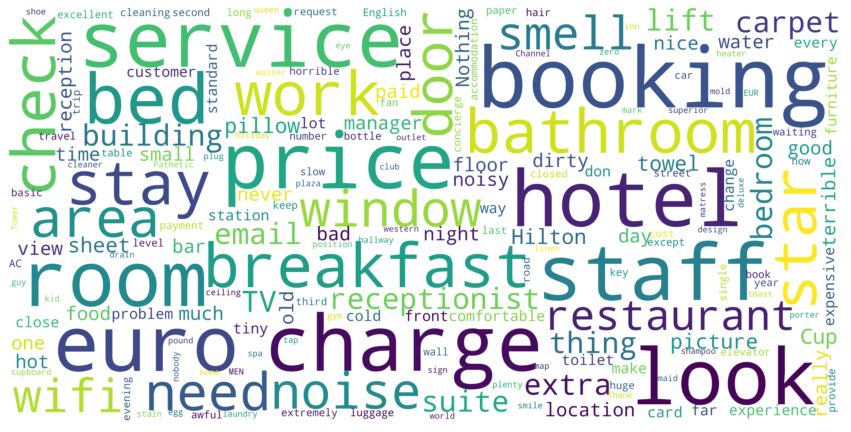

In [30]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

split_title = [x.split(" ") for x in df['reviews'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 0]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(4)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3","component_4"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 4 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, bed, breakfast, service, like, one, stay, dirty, night, us, rooms, would, even, star, good, bad, bathroom, old, shower

Topic  1
everything nothing, nothing, everything, nothing hotel, room nothing, everything location, never nothing, clean nothing, booking nothing, services nothing, rude nothing, services, regulation, regulation nothing, hotel, rude, never, staff nothing, clean, room small nothing

Topic  2
staff, helpful, rude, staff helpful, staff rude, staff location, unfriendly, friendly, rude staff, staff unfriendly, rude nothing, location, staff rude nothing, staff helpfull, unhelpful, staff friendly, helpfull, stupid, stupid staff, reception

Topic  3
location, small, small room, room, rooms, good, rooms small, room location, small room location, bad, good location, location good, old, room small, basement, poor, facilities, small rooms, value, value money

Time Taken: 10.25 seconds


In [32]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 3 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, location, small, rooms, good, bed, breakfast, service, bad, old, like, small room, poor, one, dirty, stay, night, even, bathroom

Topic  1
everything nothing, nothing, everything, nothing hotel, room nothing, everything location, never nothing, clean nothing, booking nothing, hotel, services nothing, rude nothing, services, regulation nothing, regulation, rude, never, staff nothing, booking, clean

Topic  2
staff, helpful, rude, staff helpful, staff rude, staff location, unfriendly, friendly, location, rude staff, staff unfriendly, rude nothing, staff rude nothing, reception, unhelpful, staff friendly, staff helpfull, helpfull, stupid, stupid staff

Time Taken: 5.19 seconds


In [35]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = cv_tfidf.get_feature_names())
topic_word
# Top 20 key words for each of the 2 topics
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
room, hotel, staff, location, small, rooms, good, breakfast, bed, service, bad, old, poor, like, small room, dirty, one, stay, night, bathroom

Topic  1
everything nothing, nothing, everything, nothing hotel, room nothing, everything location, never nothing, clean nothing, booking nothing, services nothing, rude nothing, hotel, rude, services, regulation, regulation nothing, never, staff nothing, staff rude nothing, booking

Time Taken: 4.88 seconds


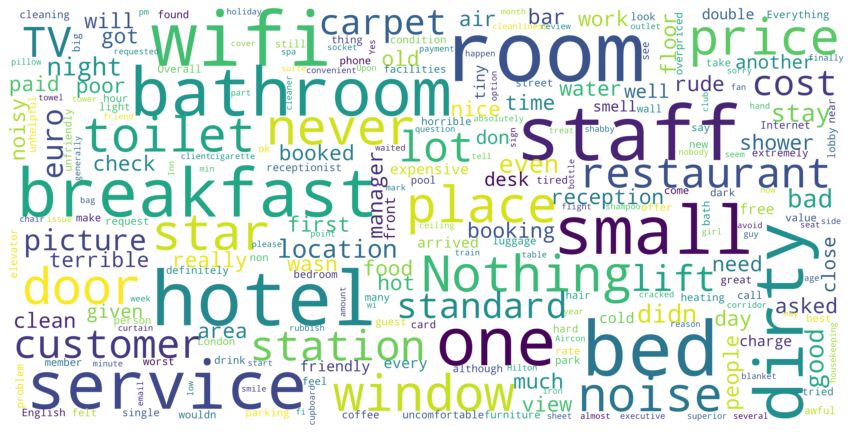

In [34]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

split_title = [x.split(" ") for x in df['reviews'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()